# Integrated Resilience Optimization Architectures


In this notebook, we use the drone model defined in `drone_mdl_opt.py` to illustrate the use of `SimpleProblem`, `ParameterSimProblem`, and `ProblemArchitecture'` classes to set up optimization architectures. Prior to viewing this study, it may be helpful to get some background on the problem and optimization architectures, thus it may be helpful to review the following references:
- Hulse, D., Biswas, A., Hoyle, C., Tumer, I. Y., Kulkarni, C., & Goebel, K. (2021). Exploring Architectures for Integrated Resilience Optimization. Journal of Aerospace Information Systems, 18(10), 665-678.
    - This reference presents a version of this Drone Optimization case study, and also introduces the concept of a resilience optimization architecture. 
    - This drone case study can further be viewed here: https://github.com/DesignEngrLab/resil_opt_examples/tree/main/Drone%20Problem
- Hulse, D., & Hoyle, C. (2022). Understanding Resilience Optimization Architectures: Alignment and Coupling in Multilevel Decomposition Strategies. Journal of Mechanical Design, 144(11), 111704.
    - This reference provides a better review of what is meant by "optimization architectures" as well as different formulations which may be used in this context. While not necessary for comprehending this demonstration, it may be helpful for understanding how it should be used in practice.

In [1]:
from drone_mdl_rural import Drone
import numpy as np

mdl = Drone()

This drone has similar structure and behaviors to the drone in `drone_mdl_hierarchical.py` (see below), encompassing the autonomous path planning, control, rotors, electrical system, and control of the drone. However, this model has been parameterized with the following parameters:

- The rotor and battery architecture can be changed
- The flight height can be changed to support different heights, which in turn changes the drone's flight plan
- There is now a `ManageHealth` function which reconfigures the flight depending on detected faults.

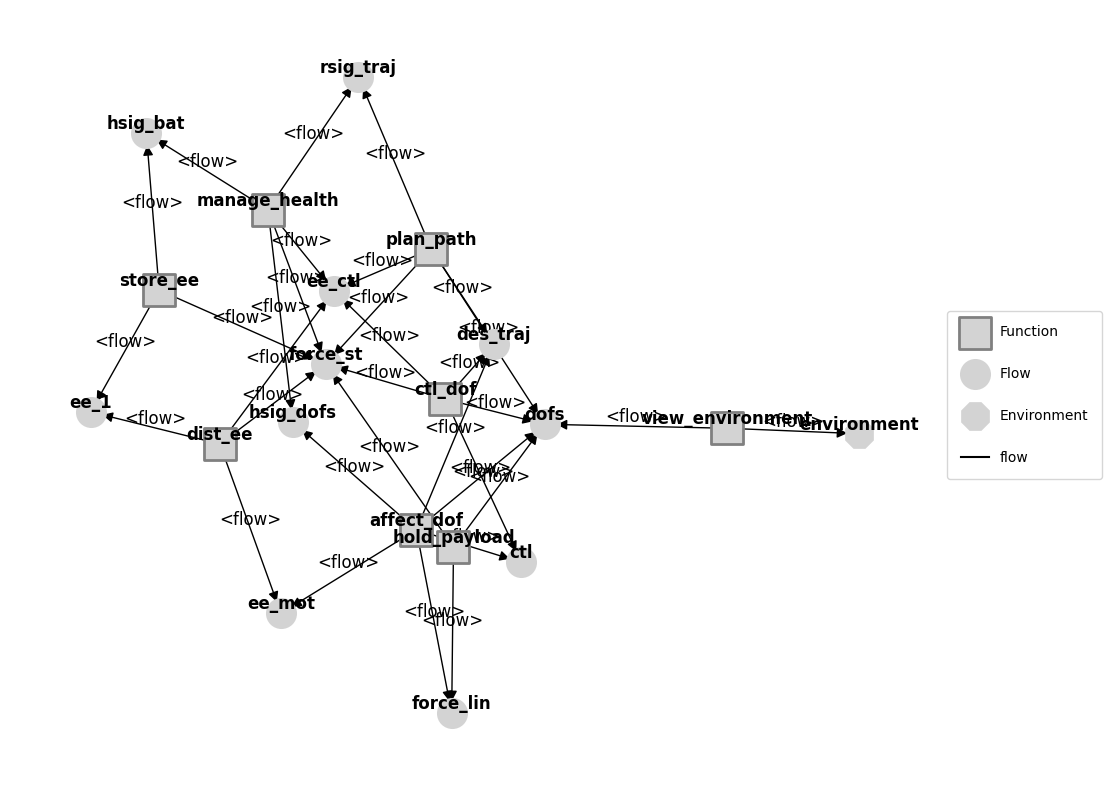

In [3]:
mg = mdl.as_modelgraph()
fig, ax = mg.draw()

This is what is called and *integrated resilience optimization* problem, the combined optimization of Design (cost of design architecture), Operations (cost/revenue of a single flight), and Resilience (cost of a set of hazardous scenarios).

Note that it is *integrated* because design model/variables (architecture) affects the operational model/variables (nominal flight), which in turn affects the resilience model (performance over scenarios).

We define each of these disciplines in `opt_drone_rural.py`, which we explain below:

## Design Model

The cost model for the architectures is fairly simple, and involves reading costs from a dictionary (rather than any sort of dictionary). As a result, we call it from an external function, as shown:

In [4]:
from fmdtools.sim.search import SimpleProblem
from examples.multirotor.opt_drone_rural import cd

des_prob = SimpleProblem("bat", "line")
des_prob.add_objective("cd", cd)
des_prob

SimpleProblem with:
VARIABLES
 -bat                                                           nan
 -line                                                          nan
OBJECTIVES
 -cd                                                            nan

We can then use the `cd` callable to the the design cost from this model in terms of the battery and line architecture variables:

In [5]:
des_prob.cd(1, 2)

2300

Note that this callable should give the same value as if we just called the identical function `x_to_dcost`:

In [6]:
from examples.multirotor.opt_drone_rural import x_to_dcost
assert des_prob.cd(1, 1) == x_to_dcost([1, 1])

## Operational Model

The operational model comes from the flight height of the drone and its performance in the nominal scenario.

To optimize this, we define a `ParameterDomain` to define the variables. Note that `xd_paramfunc` is used to translate float variable inputs into (string) options for battery/line architecture, while `plan_flight` is used to plan a given trajectory at a predetermined flight height.

In [7]:
from fmdtools.sim.sample import ParameterDomain
from examples.multirotor.drone_mdl_rural import DroneParam
from examples.multirotor.opt_drone_rural import xd_paramfunc, plan_flight

pd = ParameterDomain(DroneParam)
pd.add_variables("phys_param.bat", "phys_param.linearch", var_map=xd_paramfunc)
pd.add_variable("flightplan", var_map=plan_flight)

This parameterdomain is now callable in terms of our two variables:

In [8]:
pd(1, 1, 10)

DroneParam(respolicy=ResPolicy(bat='to_home', line='emland'), flightplan=((0.0, 0.0, 10, 10), (0.0, 0.0, 10), (-75.0, 75.0, 10), (75.0, 75.0, 10), (75.0, 85.0, 10), (-75.0, 85.0, 10), (-75.0, 95.0, 10), (75.0, 95.0, 10), (75.0, 105.0, 10), (-75.0, 105.0, 10), (-75.0, 115.0, 10), (75.0, 115.0, 10), (75.0, 125.0, 10), (-75.0, 125.0, 10), (-75.0, 135.0, 10), (75.0, 135.0, 10), (75.0, 145.0, 10), (-75.0, 145.0, 10), (-75.0, 155.0, 10), (75.0, 155.0, 10), (75.0, 165.0, 10), (-75.0, 165.0, 10), (-75.0, 175.0, 10), (75.0, 175.0, 10), (75.0, 185.0, 10), (-75.0, 185.0, 10), (-75.0, 195.0, 10), (75.0, 195.0, 10), (75.0, 205.0, 10), (-75.0, 205.0, 10), (-75.0, 215.0, 10), (75.0, 215.0, 10), (75.0, 225.0, 10), (-75.0, 225.0, 10), (0.0, 0.0, 10), (0.0, 0.0, 10, 10)), env_param=DroneEnvironmentGridParam(x_size=16, y_size=16, blocksize=10.0, state_viewed=(<class 'bool'>, False), feature_target=(<class 'bool'>, False), point_start=(0, 0), point_safe=(0, 50), loc='rural'), phys_param=DronePhysicalParam

We can now define a simulation of this model to optimize over using the `ParameterSimProblem` class.

In this case we are optimizing over the nominal simulation:

In [9]:
from fmdtools.sim.search import ParameterSimProblem
oper_prob = ParameterSimProblem(mdl, pd, "nominal", warn_faults=False)

We can then define objectives/constraints to pull from the result/history from the simulation:

Note that while results can be pulled automatically, we will want to make sure the tracking options sent to the `ParameterSimProblem` include our history variables:

In [10]:

oper_prob.add_result_objective("co", "endclass.expected_cost")
oper_prob.add_result_constraint("g_soc", "store_ee.s.soc", time=20, threshold=10)
#oper_prob.add_result_constraint("g_fault", "endfaults", metric=np.any)
oper_prob.add_history_constraint("g_max_height", "dofs.s.z", metric=np.max,
                                 threshold=122, comparator='less') 

We can now use the `co` callable (note that design variables should be sent first e.g. by calling `cd`):

In [11]:
oper_prob.co(1, 1, 100)

-50000.0

In [12]:
oper_prob.obj_con_des_res()

{'end': ['endclass.expected_cost', 'dofs.s.z'], 20: ['store_ee.s.soc']}

In [13]:
oper_prob.get_end_time()

30.0

In [14]:
oper_prob.res

t20p0.store_ee.s.soc: 48.109335294117614
end.endclass.expected_cost:     -50000.0
end.dofs.s.z:                        0.0

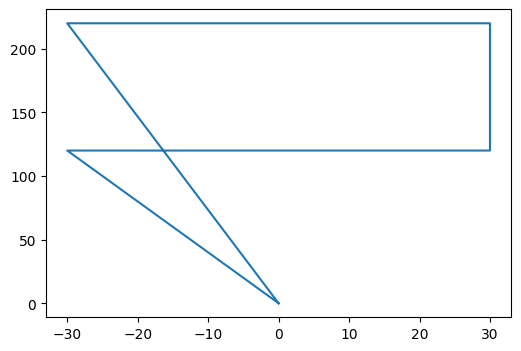

In [15]:
oper_prob.hist.plot_trajectory('flows.dofs.s.x', 'flows.dofs.s.y')

In [16]:
oper_prob.objectives

{'co': ResultObjective(name='endclass.expected_cost', value=-50000.0, negative=False, time=None, metric=<function sum at 0x00000270DDA38AF0>)}

Again, this should be the same as if we simulated manually (e.g., using `x_to_ocost`):

In [17]:
from examples.multirotor.opt_drone_rural import x_to_ocost
assert oper_prob.co(1, 1, 100) == x_to_ocost([1,1], [100])[0]

In [18]:
x_to_ocost([1,1], [100])

(-50000.0,
 -24.579923529411744,
 0,
 {'ctl_dof': PhaseMap({'nominal': [0.0, 30.0]}, {'nominal': {'nominal'}}),
  'plan_path': PhaseMap({'taxi': [0.0, 1.0], 'move': [2.0, 8.0], 'land': [9.0, 15.0], 'taxi1': [16.0, 30.0]}, {'taxi': {'taxi1', 'taxi'}, 'move': {'move'}, 'land': {'land'}})})

Note that we can view the results of these simulations by looking in `res` and `hist`, provided the history is being tracked. 

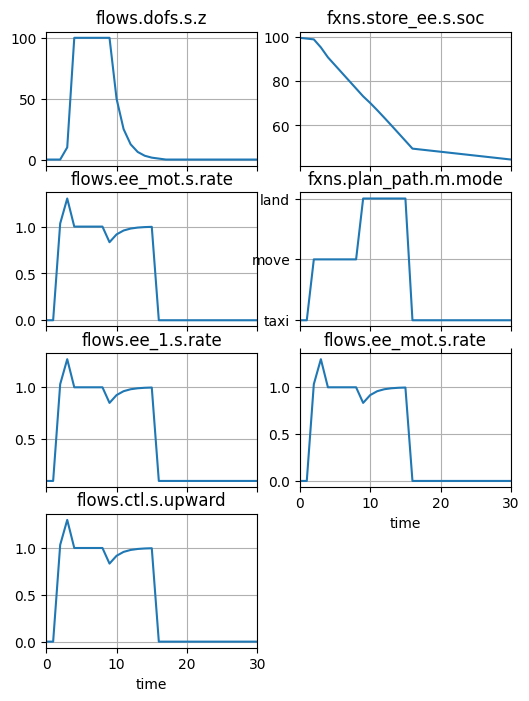

In [19]:
fig, ax = oper_prob.hist.plot_line("flows.dofs.s.z", "fxns.store_ee.s.soc", "flows.ee_mot.s.rate",
                                   "fxns.plan_path.m.mode", "flows.ee_1.s.rate", 'flows.ee_mot.s.rate',
                                   'flows.ctl.s.upward')

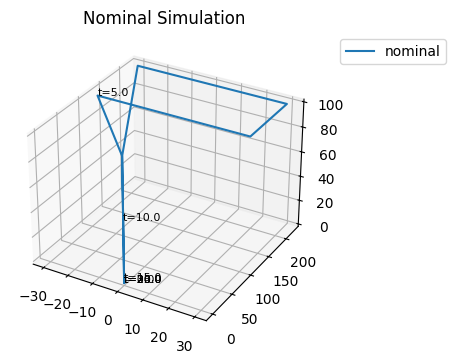

In [20]:
fig, ax = oper_prob.hist.plot_trajectories("dofs.s.x", "dofs.s.y", "dofs.s.z", title='Nominal Simulation', time_groups=['nominal'])

Note also how the cost model changes depending on the design model (Due to weight/capacity):

## Resilience Model

We can finally define a resilience optimization problem to optimize the performance over a set of scenarios.

Here we define an extended parameterdomain where the resilience policy variables are now included:

In [21]:
from examples.multirotor.opt_drone_rural import xr_paramfunc

pdr = ParameterDomain(DroneParam)
pdr.add_variables("phys_param.bat", "phys_param.linearch", var_map=xd_paramfunc)
pdr.add_variable("flightplan", var_map=plan_flight)
pdr.add_variables("respolicy.bat", "respolicy.line", var_map=xr_paramfunc)
pdr(1,1,50, 1,2)

DroneParam(respolicy=ResPolicy(bat='to_home', line='to_nearest'), flightplan=((0.0, 0.0, 10, 10), (0.0, 0.0, 50), (-55.0, 95.0, 50), (55.0, 95.0, 50), (55.0, 145.0, 50), (-55.0, 145.0, 50), (-55.0, 195.0, 50), (55.0, 195.0, 50), (55.0, 245.0, 50), (-55.0, 245.0, 50), (0.0, 0.0, 50), (0.0, 0.0, 10, 10)), env_param=DroneEnvironmentGridParam(x_size=16, y_size=16, blocksize=10.0, state_viewed=(<class 'bool'>, False), feature_target=(<class 'bool'>, False), point_start=(0, 0), point_safe=(0, 50), loc='rural'), phys_param=DronePhysicalParameters(bat='series-split', linearch='hex', batweight=0.5, archweight=1.6, archdrag=0.85))

We further define the resilience simulation. Note that the fault sample `fs` is defined as single-component battery modes.

In [22]:
from examples.multirotor.opt_drone_rural import fs

res_prob = ParameterSimProblem(mdl, pdr, "fault_sample", fs, include_nominal=False)
res_prob.add_result_objective("rcost", "endclass.expected_cost")

In [23]:
fs.faultdomain

FaultDomain with faults:
 -('store_ee', 's1p1_short')
 -('store_ee', 's1p1_degr')
 -('store_ee', 's1p1_break')
 -('store_ee', 's1p1_nocharge')
 -('store_ee', 's1p1_lowcharge')

As well as the variable for the resilience policy, which, (like the operational parameters) is translated into a parameter using the function `spec_respol`:

We can now use the callable `rcost`:

In [24]:
res_prob.rcost(1,1, 50, 1,1)

110.42166666666667

This takes this long to simulate:

In [25]:
res_prob.time_execution()

0.8542563915252686

One issue with this formulation is that it assumes a static faultsample.

However, since the length of the phases in the PhaseMap change, we may want to regenerate the sample with each variable value. We can do that by calling `fault_sample_from` from the `ParameterSimProblem`.

Figuring out the right arguments to `fault_sample_from` is challenging, so we prototype them below using `propagate.gen_sampleapproach` to verify that the faultsample generated is what we wanted.

In [26]:
from fmdtools.sim.propagate import gen_sampleapproach
from fmdtools.analyze.phases import from_hist
phases = from_hist(oper_prob.hist)
app = gen_sampleapproach(mdl,
                         faultdomains={'fd': (('singlecomp_modes', 'store_ee'), {})},
                         faultsamples={'fs': (('fault_phases', 'fd', 'move'), {'phasemap': 'plan_path'})},
                         get_phasemap=True, nomhist=oper_prob.hist)
app

SampleApproach for drone with: 
 faultdomains: fd
 faultsamples: fs

In [27]:
app.faultsamples['fs'].phasemap

PhaseMap({'taxi': [0.0, 1.0], 'move': [2.0, 8.0], 'land': [9.0, 15.0], 'taxi1': [16.0, 30.0]}, {'taxi': {'taxi1', 'taxi'}, 'move': {'move'}, 'land': {'land'}})

In [28]:
app.scenarios()

[SingleFaultScenario(sequence={5.0: Injection(faults={'store_ee': ['s1p1_short']}, disturbances={})}, times=(5.0,), function='store_ee', fault='s1p1_short', rate=7e-07, name='store_ee_s1p1_short_t5p0', time=5.0, phase='move'),
 SingleFaultScenario(sequence={5.0: Injection(faults={'store_ee': ['s1p1_degr']}, disturbances={})}, times=(5.0,), function='store_ee', fault='s1p1_degr', rate=7e-07, name='store_ee_s1p1_degr_t5p0', time=5.0, phase='move'),
 SingleFaultScenario(sequence={5.0: Injection(faults={'store_ee': ['s1p1_break']}, disturbances={})}, times=(5.0,), function='store_ee', fault='s1p1_break', rate=7e-07, name='store_ee_s1p1_break_t5p0', time=5.0, phase='move'),
 SingleFaultScenario(sequence={5.0: Injection(faults={'store_ee': ['s1p1_nocharge']}, disturbances={})}, times=(5.0,), function='store_ee', fault='s1p1_nocharge', rate=1.4000000000000001e-06, name='store_ee_s1p1_nocharge_t5p0', time=5.0, phase='move'),
 SingleFaultScenario(sequence={5.0: Injection(faults={'store_ee': ['s

We may also want to provide a multiprocessing pool to speed the simulation up:

In [29]:
from multiprocessing import Pool
pool = Pool(5)

Now that we know what arguments to use, we can construct the resilience problem:

In [30]:
res_prob = ParameterSimProblem(mdl, pdr, "fault_sample_from",
                               faultdomains={'fd': (('singlecomp_modes', 'store_ee'), {})},
                               faultsamples={'fs': (('fault_phases', 'fd', 'move'), {'phasemap': 'plan_path'})},
                               get_phasemap=True,
                               include_nominal=False,
                               pool=pool,
                               close_pool=False,
                               warn_faults=False)
res_prob.add_result_objective("rcost", "endclass.expected_cost")

In [31]:
res_prob.rcost(2, 2, 40, 0, 1)

1269.125

In [32]:
res_prob.time_execution(reps=10)

0.6060441255569458

Note that this should produce identical values to the manually-constructed `x_to_rcost`:

In [33]:
from examples.multirotor.opt_drone_rural import x_to_rcost
a = res_prob.rcost(2, 2, 40, 2, 2)
b = x_to_rcost([2, 2], [40], [2, 2])

Faults found during the nominal run {'store_ee': ['s1p2_lowcharge', 'lowcharge', 's1p1_lowcharge']}
Faults found during the nominal run {'store_ee': ['s1p2_lowcharge', 'lowcharge', 's1p1_lowcharge']}


In [34]:
assert abs(a - b) < 0.00001

## Combined Simulation/Optimization

These optimization problems are clearly related, and so we may want to optimize them together. We can combine them into one big problem using `ProblemArchitecture`:

In [35]:
from fmdtools.sim.search import ProblemArchitecture
prob_arch = ProblemArchitecture()

To set up a problem architecture, we should first define some shared variables. In this prolbem it is the battery and line architecture, as well as the flightplan (z):

In [36]:
prob_arch.add_connector_variable("xd", "bat", "line")
prob_arch.add_connector_variable("xo", "flightplan")

We can then add the problems using `add_problem`, specifying what connectors for each correspond to inputs and outputs of the problem.

In this case, the design problem outputs the battery and line architecture to both the operational and resilience problem while the operational problem outputs the flightplan to the resilience problem.

In [37]:
prob_arch.add_problem("des", des_prob, outputs={"xd": ("bat", "line")})
prob_arch.add_problem("oper", oper_prob,
                      inputs={"xd": ("phys_param.bat", "phys_param.linearch")},
                      outputs={"xo": ("flightplan",)})
prob_arch.add_problem("res", res_prob,
                      inputs={"xd": ("phys_param.bat", "phys_param.linearch"),
                              "xo": ("flightplan",)})

We can visualize this architecture using:

In [38]:
prob_arch

ProblemArchitecture with:
CONNECTORS
 -xd                                                      [nan nan]
 -xo                                                          [nan]
PROBLEMS
 -des({'des_xloc': ['bat', 'line']}) -> ['xd']
 -oper({'xd': ('phys_param.bat', 'phys_param.linearch'), 'oper_xloc': ['flightplan']}) -> ['xo']
 -res({'xd': ('phys_param.bat', 'phys_param.linearch'), 'xo': ('flightplan',), 'res_xloc': ['respolicy.bat', 'respolicy.line']}) -> []
VARIABLES
 -des_xloc                                                [nan nan]
 -oper_xloc                                                   [nan]
 -res_xloc                                                [nan nan]
OBJECTIVES
 -des_cd                                                  1300.0000
 -oper_co                                                       nan
 -res_rcost                                                     nan
CONSTRAINTS
 -oper_g_soc                                                    nan
 -oper_g_max_height           

or:

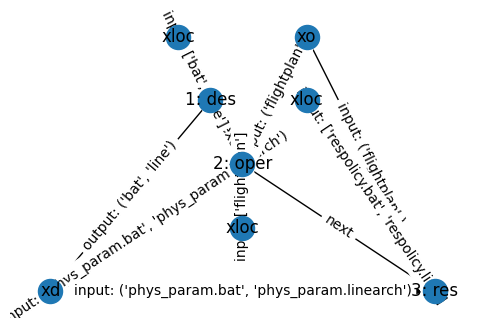

In [39]:
fig, ax = prob_arch.show_sequence()

We can now interact with callables for each of the three objectives:

In [40]:
prob_arch.des_cd(1,1)

1300

In [41]:
prob_arch.oper_co(50)

-9950000.0

In [42]:
prob_arch.res_rcost(1, 1)

94.39833333333334

These can also be called in terms of the full set of variables:

In [43]:
prob_arch.res_rcost_full(1,1, 50, 1, 1)

94.39833333333334

We can calculate the total computational time of this below:

In [44]:
prob_arch.time_execution(reps=10)

0.729421877861023

In [45]:
prob_arch.constraints

{'oper_g_soc': -28.579923529411722, 'oper_g_max_height': -72.0}

### Optimization
Below we show a very simple optimization of these variables using brute force search. Much more sophisticated architectures/methods can be used on this problem, this code is mainly to demonstrate how these disciplines can be used together as a single objective/problem.

In [46]:
import itertools
def brute_search(prob_arch, Xranges = [[0,4,1],[0,3,1],[10, 130, 10],[0,4,1],[0,4,1]], skip_iter = False):
    Xvals = [ e for e in itertools.product(*(range(x[0],x[1],x[2]) for x in Xranges))]
    opt_hist = []
    iter = 0
    for X in Xvals:
        dcost = prob_arch.des_cd(*X[:2])
        ocost = prob_arch.oper_co(X[2])
        rcost = prob_arch.res_rcost(*X[3:])
        tot_cost = dcost + ocost + rcost
        is_feasible = all([v<=0.0 for v in prob_arch.constraints.values()])
        if not opt_hist:
            opt_hist= [[tot_cost, X]]
        elif tot_cost < opt_hist[-1][0] and is_feasible:
            opt_hist.append([tot_cost, X])
        if skip_iter <= iter and skip_iter:
            break
        else:
            iter += 1

    return opt_hist

In [47]:
opt_hist = brute_search(prob_arch, skip_iter=20)

Note that given the sim time of ~0.5s, the full execution time should take:

In [48]:
Xranges = [[0,4,1],[0,3,1],[10, 130, 10],[0,4,1],[0,4,1]]
Xvals = [ e for e in itertools.product(*(range(x[0],x[1],x[2]) for x in Xranges))]
len(Xvals) * 0.4 /60

15.360000000000001

In [49]:
# opt_hist = brute_search(skip_iter=10)

The full history of objective values can be viewed in `iter_hist`:

In [50]:
prob_arch.iter_hist

time:                          array(99)
variables: 
--des_xloc: 
----bat:                      array(100)
----line:                     array(100)
--oper_xloc: 
----flightplan:               array(100)
--res_xloc: 
----respolicy.bat:            array(100)
----respolicy.line:           array(100)
objectives: 
--des_cd:                      array(99)
--oper_co:                     array(99)
--res_rcost:                   array(99)
constraints: 
--oper_g_soc:                  array(99)
--oper_g_max_height:           array(99)

see:

(<Figure size 600x400 with 4 Axes>,
 array([<Axes: title={'center': 'objectives.res_rcost'}, xlabel=' '>,
        <Axes: title={'center': 'objectives.des_cd'}, xlabel='time'>,
        <Axes: title={'center': 'objectives.oper_co'}, xlabel='time'>,
        <Axes: >], dtype=object))

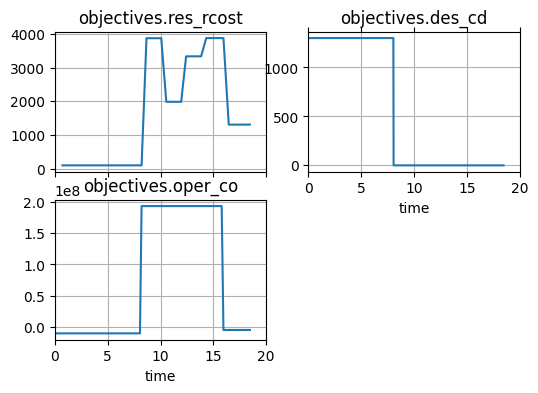

In [51]:
prob_arch.iter_hist.plot_line("objectives.res_rcost", "objectives.des_cd", "objectives.oper_co")

(of course, we also recorded a history in the function)

In [52]:
opt_hist

[[193253874.255, (0, 0, 10, 0, 0)],
 [193251983.455, (0, 0, 10, 1, 0)],
 [-4548694.605, (0, 0, 20, 0, 0)]]

In [53]:
pool.close()
pool.terminate()

This illustrates the use of a monolithic optimization architecture for exploring the variables in these sims. We could create more, per the references, or use specialized methods to speed up the search:
- e.g., using one of the architectures (bilevel, multi-stage, etc) defined previously
- searching the variables with a specialized optimization method (e.g., tree search)
- Setting the policy as a disturbance, rather than a parameter. This would enable staged execution of the resilience scenarios, greatly decreasing computational time.